# 13.3 梯度不平稳性与Glorot条件

从本节开始，将正式进入到优化方法的具体方法部分内容。首先是关于激活函数使用过程的优化，在上一节的结尾，我们发现，尽管激活函数的使用能够有效提升神经网络模型效果，但激活函数的简单叠加却会让模型出现很多问题。深度学习本来就是深层次神经网络，如果不解决激活函数在叠加过程中遇到的问题，深层次神经网络也就无从构建。

本节将从上一节建模过程中所遇到的，堆叠激活函数之后遇到的问题入手，讨论造成这些问题的根源，以及如何通过一些优化方法解决这些问题。

* 模型病灶与模型调优

在正式进入到模型优化方法之前，我们需要简单了解到底什么是模型优化。有很多初学者会简单的认为模型优化方法就是能够让模型得出更好的结果的方法，但实际上模型优化更像是对‘患病’的模型进行诊断，然后对症下药，通过这些治疗方法，最终让模型运行恢复正常且健康的状态，并得出较好的模型预测结果。尽管优化方法就像一种种药品，各自都标注了适用的病症，但深度学习模型在某种程度上就像人体一样，是个非常复杂的系统，很多时候并不是‘A要治疗A病’，并不是一个‘只要...就..’的命题。模型优化就像疾病治疗一样，很多时候都是各种手段作用于复杂的系统，最终通过这个复杂系统自身的特性发挥作用。业余算法工程师进行模型调优就像我们平时取药店买药，啥病买啥药，然后挑个最贵的；而专业的苏阿芙娜工程师进行模型调优则更像是医生为患者进行诊断，在了解病理的基础上，通过一系列更加专业的诊断手段判断病情，然后提出更加高效的综合解决方案。

因此，初级算法工程师只需要知道模型会有什么样的问题（什么病）以及分别可以用什么办法解决（都有什么药），模型调优主要靠套用和反复调试（多尝试各种方法），而更加专业的算法工程师则需要知道这些模型问题背后的成因，也就是什么原因导致了模型出现这些问题（病理），同时也需要掌握更加丰富的诊疗手段以诊断模型的问题（不仅仅是看模型评估指标结果），然后了解优化方法的基本原理以及发挥作用的方式，当然至关重要的一段是需要在长期实践中不断积累经验，才能最终获得专业性的长足的进步。

正是出于这些角度的考虑，在优化方法的内容中，我们不仅会介绍每一种方法发挥作用的场景，更重要的是我们会同步介绍深度学习模型在建模过程

## 13.3.1 梯度消失与梯度爆炸

对于神经网络这个复杂系统来说，在模型训练过程中，一个最基础，同时也最常见的问题，就是梯度消失和梯度爆炸。

我们知道，神经网络在进行反向传播的过程中，各参数层的梯度计算会涉及到激活函数导函数取值，具体来说，假设现在有一个三层神经网络，其中两个隐藏层的激活函数为$F（x）$，对应的导函数为$f(x)$，设X为输入训练的数据特征，$y$为标签，$yhat$为模型向前传播输出结果，$w1$为第一层参数，$w2$为第二层参数，$w3$为第三层参数，$loss$为损失函数，则有如下计算公式：

每一次正向传播结果：

$$ yhat = F(F(X * w_{1}) * w_{2}) * w_{3} $$

而$ loss $ 是一个关于 $ y $ 和 $ yhat $的函数，而 $ y $ 是常量，$ yhat $ 是一个关于$ w $ 的函数，因此，$ loss $也进行如下表示：

$$ loss(yhat) $$

在进行梯度求解时候，假设$ w_{1} $ 对应梯度为 $ grad_{1} $ ，$ w_{2} $ 对应梯度为 $ grad_{2} $，$ w_{3} $ 对应梯度为 $ grad_{3} $，为了简化计算，我们假设所有的$ w_{1} $，$ w_{2} $，$ w_{3} $ 都是标量，根据链式法则，有计算过程如下：



$$
\begin{aligned}
\operatorname{grad}_1 & =\frac{\partial l o s s}{\partial w_1} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_1} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial\left(F\left(F\left(X * w_1\right) * w_2\right) * w_3\right)}{\partial w_1} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial\left(F\left(F\left(X * w_1\right) * w_2\right) * w_3\right)}{\partial\left(F\left(F\left(X * w_1\right) * w_2\right)\right.} \cdot \frac{\partial F\left(F\left(X * w_1\right) * w_2\right)}{\partial F\left(X * w_1\right)} \cdot \frac{\partial F\left(X * w_1\right)}{\partial w_1} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot w_2 \cdot f\left(X * w_1\right) \cdot X
\end{aligned}
$$

值得注意的是，此时 $ grad_{1} $ 中计算了两次激活函数的导函数，并且在上述过程中，$ x* w_{1} $ 是第一层隐藏层接收到的数据，而$ F(x * w_{1})* w_{2} $ 则是第二层隐藏层接收到的数据。而如果是计算$ w_{2} $ 的梯度，则有如下过程：



$$
\begin{aligned}
\operatorname{grad}_2 & =\frac{\partial l o s s}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial\left(F\left(F\left(X * w_1\right) * w_2\right) * w_3\right)}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial\left(F\left(F\left(X * w_1\right) * w_2\right) * w_3\right)}{\partial\left(F\left(F\left(X * w_1\right) * w_2\right)\right.} \cdot \frac{\partial F\left(F\left(X * w_1\right) * w_2\right)}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot \frac{\partial F\left(F\left(X * w_1\right) * w_2\right)}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot \frac{\partial\left(F\left(X * w_1\right) * w_2\right)}{\partial w_2} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot F\left(X * w_1\right)
\end{aligned}
$$

我们发现，在计算过程中只出现了一次激活函数的导函数，当然如果我们是计算$ w_{3} $ 的梯度，则有如下计算过程：

$$
\begin{aligned}
\operatorname{grad}_3 & =\frac{\partial l o s s}{\partial w_3} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_3} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot \frac{\partial\left(F\left(F\left(X * w_1\right) * w_2\right) * w_3\right)}{\partial w_3} \\
& =\frac{\partial l o s s}{\partial \hat{y}} \cdot F\left(F\left(X * w_1\right) * w_2\right)
\end{aligned}
$$

此时$ grad_{3} $ 在计算过程中就已经不涉及激活函数的导函数的计算了。

其实如果当神经网络层数继续增加，激活函数的数量继续增加，第一层参数在计算梯度的过程中需要相乘的激活函数导函数个数也会随着增加，而后面几层参数的梯度计算过程中涉及到的激活函数导函数个数逐级递减。

    当然，上述过程如果换成矩阵求导，公式主体部分基本不变，只有最后一项会发生变化。由于最终运算结果无法写成较为简洁的矩阵运算形式（矩阵变元的实向量函数），因此此处以标量运算为例。

而累乘就容易造成指数级变化，当激活函数值$F（F（X * w1））$，激活函数导函数值$ f（X * w1）$ 或者参与相乘的参数取值$ (w_{3}) $ 较大（>1）时，就会出现 $ grad_{1} $ 远大于$ grad_{2} $，远大于$ grad_{3} $ 的情况，也就是神经网络前几层参数梯度非常大，而后几层参数梯度相对较小的情况，此时就被称为梯度爆炸，并且受到累积效应的影响，前几层梯度也会大于甚至远大于1,此时就会造成模型迭代过程不稳定的情况发生；而反之如果上述几个变量均小于1,甚至远小于1,则会出现前几层梯度非常小，而后几层参数梯度非常大的情况，此时就被称为梯度消失，此时由于模型各层参数学习率伴随层数增加逐渐增大，并且由于构成梯度的基本参数基本小于1,因此最后几层梯度也会小于1甚至远小于1,此时前几层参数梯度取值将非常小，甚至趋于0,因而会使得前几层的参数无法在迭代中得到更新。

总结一下，不同参数的梯度在计算工程中都有很大的差异，并且这种差异是一种累积效应，我们也可以简单理解为是一种伴随着层数增加指数级变化的差异。而这种累乘效应会导致线性层参数的一部分梯度过大，而另一部分梯度过小，从而影响模型平稳训练。而从具体原因来说，每一层的梯度和两个因素相关，分其一是线性层输入数据，如X或F（X * W）， 其二则是激活函数导函数计算结果f(X *W1)。

接下来，我们就从梯度消失和梯度爆炸角度剖析Sigmoid和tanh激活函数叠加过程中可能存在的隐患。

## 13.3.2 Sigmoid和tanh激活函数的梯度更新问题

### 13.3.2.1 Sigmoid激活函数的梯度消失问题

* 理论说明

对于sigmoid激活函数来说，简单的叠加是极容易出现梯度消失的问题。Sigmoid函数及导函数图像如下所示：

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


In [2]:
# 绘制Sigmoid激活函数的函数图像和导函数
x = torch.arange(-5, 5, 0.1)
x.requires_grad = True
sigmoid_y = torch.sigmoid(x)

In [3]:
# 反向传播
sigmoid_y.sum().backward()

Text(0.5, 1.0, 'sigmoid derivative function')

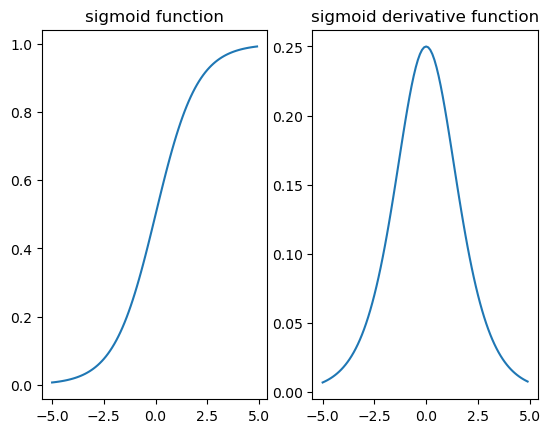

In [4]:
# Sigmoid函数图像
plt.subplot(121)
plt.plot(x.detach(), sigmoid_y.detach())
plt.title('sigmoid function')

# Sigmoid函数导函数图像
plt.subplot(122)
plt.plot(x.detach(), x.grad.detach())
plt.title('sigmoid derivative function')

我们发现，Sigmoid导函数最大值为0.25（在0点处取到），当x较大或者较小时，导函数取值趋于1.

此时如果我们假设还是上述结构的三层神经网络，则第一层参数梯度 $ gard_{1} $由于计算过程出现两次导函数连乘，哪怕两次都导函数取到最大值（虽然可能性较小），$ gard_{1} $都将在0.0625的基础上进行其余部分相乘，最终结果也极有可能是个非常小的值，因此对于Sigmoid激活函数叠加的情况来说，是极容易出现梯度消失情况的。

$$
\begin{gathered}
\operatorname{grad}_1=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot w_2 \cdot f\left(X * w_1\right) \cdot X \\
\operatorname{grad}_2=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot F\left(X * w_1\right) \\
\operatorname{grad}_3=\frac{\partial l o s s}{\partial \hat{y}} \cdot F\left(F\left(X * w_1\right) * w_2\right)
\end{gathered}
$$

    梯度消失或者梯度爆炸，始终是个概率问题，我们不能说导函数取值小就一定会发生梯度消失问题，只是导函数最大值越小，越有可能发生梯度消失。

* Sigmoid函数饱和区间

一般来说我们会将靠近Sigmoid函数的左右两端的区间称为饱和区间（如下图圆圈圈出部分）（也就是自变量绝对值较大的区间），不难发现，当自变量落入饱和区间时，因变量会趋于0或者1,而无论自变量是极小（负数绝对值极大）还是极大，都会使得导函数取值趋于0,从而更容易导致模型梯度消失。

![Alt text](image-41.png)

* Sigmoid激活函数叠加后的梯度消失问题

接下来，我们通过创建一个实例来观察Sigmoid激活函数叠加后梯度消失问题。

In [5]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w= [2, -1], bias= False, deg= 2)

# 进行数据集切分于加载
train_loader, test_loader = split_loader(features, labels)

然后使用此前定义的，拥有三个隐藏层的Sigmoid_class3模型进行建模。

In [6]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
sigmoid_model3 = Sigmoid_class3()

然后让我们来观察各层参数的梯度随着迭代过程变化情况。

---

# 模型参数及梯度提取方法

由于需要对各线性层参数的变化情况进行观察，此处我们也简单总结此前提到的关于模型参数及其对应梯度的提取方法。首先是利用.parameters（）方法观察模型所有参数。

In [7]:
pl = list(sigmoid_model3.parameters())
pl

[Parameter containing:
 tensor([[ 0.4318, -0.4256],
         [ 0.6730, -0.5617],
         [-0.2157, -0.4873],
         [ 0.5453,  0.2653]], requires_grad=True),
 Parameter containing:
 tensor([-0.3527, -0.5469, -0.4094, -0.1364], requires_grad=True),
 Parameter containing:
 tensor([[-0.2552,  0.3644, -0.2104, -0.3271],
         [-0.1542, -0.4883, -0.2428, -0.2728],
         [ 0.1076,  0.4066,  0.0540, -0.2914],
         [ 0.2058, -0.2129, -0.2367, -0.0958]], requires_grad=True),
 Parameter containing:
 tensor([-0.2609,  0.0550,  0.4059,  0.0682], requires_grad=True),
 Parameter containing:
 tensor([[ 3.0199e-01, -4.3436e-01, -3.9335e-01, -6.6525e-02],
         [ 4.5806e-04,  3.1209e-01, -4.3974e-01,  2.0861e-01],
         [-4.2916e-01,  8.0655e-02,  3.3044e-01,  6.8971e-02],
         [ 1.5964e-01,  3.1789e-01,  4.9465e-01, -3.1377e-01]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1638,  0.4116,  0.2843, -0.4529], requires_grad=True),
 Parameter containing:
 tensor(

.parameters()方法返回模型所有参数，包括截距，但需要使用list将其转化为显式的列表。此时列表中的每个元素都是带名称的张量，并且是可微张量即可。并且，就像此前说到的一样，推导过程中我们使用数据是按照行排列，一行代表一条数据，一列代表数据的一个特征，而PyTorch在进行计算时，会将数据转化为按列排列，一列代表一条数据，因此PyTorch中我们查看到的模型参数和推导的模型参数互为转置关系。我们可以通过如下过程简单说明：

In [8]:
f = torch.tensor([[1., 2]])
f

tensor([[1., 2.]])

In [9]:
sigmoid_model3(f)

tensor([[-0.5715]], grad_fn=<AddmmBackward0>)

In [10]:
sigmoid_model3.modules()

<generator object Module.modules at 0x7f269b703760>

In [11]:
list(sigmoid_model3.modules())

[Sigmoid_class3(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=4, bias=True)
   (out): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=1, bias=True)]

In [12]:
list(sigmoid_model3.modules())[1](f)    # 返回模型第一层输出结果

tensor([[-0.7721, -0.9973, -1.5997,  0.9395]], grad_fn=<AddmmBackward0>)

In [13]:
torch.mm(f, pl[0].t()) + pl[1].t()      # 手动实现

tensor([[-0.7721, -0.9973, -1.5997,  0.9395]], grad_fn=<AddBackward0>)

当然，我们还可以通过.module方法，观察构成该模型的每个线性层的参数。

In [14]:
ml = list(sigmoid_model3.modules())
ml

[Sigmoid_class3(
   (linear1): Linear(in_features=2, out_features=4, bias=True)
   (linear2): Linear(in_features=4, out_features=4, bias=True)
   (linear3): Linear(in_features=4, out_features=4, bias=True)
   (out): Linear(in_features=4, out_features=1, bias=True)
 ),
 Linear(in_features=2, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=4, bias=True),
 Linear(in_features=4, out_features=1, bias=True)]

ml中，除了第一个元素时自定义的类以外，其他的都是构成模型的线性层。

In [15]:
list(ml[0].parameters())    # ml中的第一个元素和模型相同

[Parameter containing:
 tensor([[ 0.4318, -0.4256],
         [ 0.6730, -0.5617],
         [-0.2157, -0.4873],
         [ 0.5453,  0.2653]], requires_grad=True),
 Parameter containing:
 tensor([-0.3527, -0.5469, -0.4094, -0.1364], requires_grad=True),
 Parameter containing:
 tensor([[-0.2552,  0.3644, -0.2104, -0.3271],
         [-0.1542, -0.4883, -0.2428, -0.2728],
         [ 0.1076,  0.4066,  0.0540, -0.2914],
         [ 0.2058, -0.2129, -0.2367, -0.0958]], requires_grad=True),
 Parameter containing:
 tensor([-0.2609,  0.0550,  0.4059,  0.0682], requires_grad=True),
 Parameter containing:
 tensor([[ 3.0199e-01, -4.3436e-01, -3.9335e-01, -6.6525e-02],
         [ 4.5806e-04,  3.1209e-01, -4.3974e-01,  2.0861e-01],
         [-4.2916e-01,  8.0655e-02,  3.3044e-01,  6.8971e-02],
         [ 1.5964e-01,  3.1789e-01,  4.9465e-01, -3.1377e-01]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1638,  0.4116,  0.2843, -0.4529], requires_grad=True),
 Parameter containing:
 tensor(

In [16]:
ml[1]

Linear(in_features=2, out_features=4, bias=True)

In [17]:
ml[1].weight

Parameter containing:
tensor([[ 0.4318, -0.4256],
        [ 0.6730, -0.5617],
        [-0.2157, -0.4873],
        [ 0.5453,  0.2653]], requires_grad=True)

In [18]:
ml[1].bias

Parameter containing:
tensor([-0.3527, -0.5469, -0.4094, -0.1364], requires_grad=True)

同时，单独的线性层也可视为独立的‘模型’，输入数据也可以输出结果，此时结果相当于时模型中间结果。

In [19]:
ml[1](f)

tensor([[-0.7721, -0.9973, -1.5997,  0.9395]], grad_fn=<AddmmBackward0>)

因此，我们目前所使用的模型，也可以称为线性层叠加模型。不过这种线性层模块单独提取参数的方法需要注意，每一个线性层的weight和bias（如果有的话）是单独的属性，实际建模过程中需要视情况提取weight或者bias。

In [20]:
# 提取weight
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight)

Parameter containing:
tensor([[ 0.4318, -0.4256],
        [ 0.6730, -0.5617],
        [-0.2157, -0.4873],
        [ 0.5453,  0.2653]], requires_grad=True)
Parameter containing:
tensor([[-0.2552,  0.3644, -0.2104, -0.3271],
        [-0.1542, -0.4883, -0.2428, -0.2728],
        [ 0.1076,  0.4066,  0.0540, -0.2914],
        [ 0.2058, -0.2129, -0.2367, -0.0958]], requires_grad=True)
Parameter containing:
tensor([[ 3.0199e-01, -4.3436e-01, -3.9335e-01, -6.6525e-02],
        [ 4.5806e-04,  3.1209e-01, -4.3974e-01,  2.0861e-01],
        [-4.2916e-01,  8.0655e-02,  3.3044e-01,  6.8971e-02],
        [ 1.5964e-01,  3.1789e-01,  4.9465e-01, -3.1377e-01]],
       requires_grad=True)
Parameter containing:
tensor([[-0.3468, -0.4897,  0.2213,  0.4947]], requires_grad=True)


注释： isinstance是一个Python内置的函数，用于检查一个对喜是否属于指定的类或者类型。它的一般用法如下：

    isinstance(object, classinfo)

* 'object': 要检查的对象。
* ‘classinfo':可以是一个类，类型或者由类组成的元组。如果’object'是'classinfo'指定指定的类或者类型之一，'isinstance'返回‘True’；否则返回‘False'。

当然，我们也可以直接使用.grad查看梯度。但由于目前模型还未训练，因此返回结果为None。后续查看每一个线性层梯度时可以使用如下方法：

In [21]:
# 提取梯度
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

None
None
None
None


有了上述基础知识铺垫之后，即可以开始后续的学习。

---

接下来，对模型进行训练，在遍历五次数据后，观察参数变化情况。

In [22]:
fit(net= sigmoid_model3,
    criterion= nn.MSELoss(),
    optimizer= optim.SGD(sigmoid_model3.parameters(), lr= 0.03),
    batchdata= train_loader,
    epochs= 5,
    cla= False)

In [23]:
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight)

Parameter containing:
tensor([[ 0.4372, -0.4246],
        [ 0.7055, -0.5486],
        [-0.2128, -0.4854],
        [ 0.5289,  0.2731]], requires_grad=True)
Parameter containing:
tensor([[-0.2624,  0.3539, -0.2097, -0.3360],
        [-0.1441, -0.4683, -0.2514, -0.2627],
        [ 0.1494,  0.4727,  0.0456, -0.2496],
        [ 0.1916, -0.2341, -0.2344, -0.1131]], requires_grad=True)
Parameter containing:
tensor([[ 0.2618, -0.4739, -0.4603, -0.1163],
        [-0.0543,  0.2618, -0.5319,  0.1416],
        [-0.4360,  0.0395,  0.3270,  0.0522],
        [ 0.1733,  0.2853,  0.5280, -0.3078]], requires_grad=True)
Parameter containing:
tensor([[-0.0287, -0.1232,  0.5845,  0.7604]], requires_grad=True)


通过和模型训练前的权重对比，不难看出，第一层线性层参数变化非常小，而最后一层参数变化较大。不过这种观察还是比较粗糙的。我们希望能够观察到每一轮迭代结束后各层参数的梯度。由于我们定义的fit函数时在每一轮开始时将梯度清零，而每一轮迭代结束时还会保留梯度，因此我们可以直接使用.grad查看当前各层参数梯度情况。

    关于训练模型时每一轮开始时清零梯度还是结束时清零梯度，本质上效果相同，由于此处我们需要查看每一轮迭代完的梯度，因此此前的函数创建时采用每轮开始时清除上一轮梯度的设置。

In [24]:
for m in sigmoid_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-0.0043, -0.0027],
        [-0.0176, -0.0117],
        [-0.0040, -0.0021],
        [ 0.0098,  0.0052]])
tensor([[ 0.0062,  0.0077, -0.0007,  0.0115],
        [-0.0107, -0.0133,  0.0014, -0.0202],
        [-0.0341, -0.0421,  0.0027, -0.0627],
        [ 0.0124,  0.0154, -0.0012,  0.0229]])
tensor([[ 0.0066,  0.0060,  0.0113,  0.0083],
        [ 0.0209,  0.0191,  0.0359,  0.0265],
        [-0.0773, -0.0708, -0.1329, -0.0979],
        [-0.1050, -0.0960, -0.1804, -0.1329]])
tensor([[-0.6299, -0.7897, -0.8889, -0.7292]])


从上述结果可以看出前几层梯度较小，后几层梯度较大。当然，一种更加直观的观测手段，是通过绘制小提琴图来对各层梯度进行观察，具体过程如下：

In [25]:
import seaborn as sns   # 导入seaborn绘图包

In [26]:
vp = []         # 创建空列表用于存储每一层参数的梯度

In [27]:
for i, m in enumerate(sigmoid_model3.modules()):
    if isinstance(m, nn.Linear):
        vp_x = m.weight.grad.detach().reshape(-1, 1).numpy()    # 每一层参数梯度
        vp_y = np.full_like(vp_x, i)        # 对层进行标记
        vp_a = np.concatenate((vp_x, vp_y), 1)
        vp.append(vp_a)

In [28]:
vp

[array([[-0.00434157,  1.        ],
        [-0.00269753,  1.        ],
        [-0.01757522,  1.        ],
        [-0.01171168,  1.        ],
        [-0.00395311,  1.        ],
        [-0.00208128,  1.        ],
        [ 0.00981918,  1.        ],
        [ 0.0052211 ,  1.        ]], dtype=float32),
 array([[ 6.23246841e-03,  2.00000000e+00],
        [ 7.73868850e-03,  2.00000000e+00],
        [-6.50474394e-04,  2.00000000e+00],
        [ 1.15341200e-02,  2.00000000e+00],
        [-1.06804892e-02,  2.00000000e+00],
        [-1.33101316e-02,  2.00000000e+00],
        [ 1.41562242e-03,  2.00000000e+00],
        [-2.02342980e-02,  2.00000000e+00],
        [-3.41279805e-02,  2.00000000e+00],
        [-4.21172082e-02,  2.00000000e+00],
        [ 2.70338310e-03,  2.00000000e+00],
        [-6.27222508e-02,  2.00000000e+00],
        [ 1.24284355e-02,  2.00000000e+00],
        [ 1.54135944e-02,  2.00000000e+00],
        [-1.21727341e-03,  2.00000000e+00],
        [ 2.29195934e-02,  2.000000

In [29]:
vp[0]

array([[-0.00434157,  1.        ],
       [-0.00269753,  1.        ],
       [-0.01757522,  1.        ],
       [-0.01171168,  1.        ],
       [-0.00395311,  1.        ],
       [-0.00208128,  1.        ],
       [ 0.00981918,  1.        ],
       [ 0.0052211 ,  1.        ]], dtype=float32)

In [30]:
vp_r = np.concatenate((vp), 0)          # 拼接行
vp_r

array([[-4.34156787e-03,  1.00000000e+00],
       [-2.69753160e-03,  1.00000000e+00],
       [-1.75752211e-02,  1.00000000e+00],
       [-1.17116775e-02,  1.00000000e+00],
       [-3.95311136e-03,  1.00000000e+00],
       [-2.08128500e-03,  1.00000000e+00],
       [ 9.81917512e-03,  1.00000000e+00],
       [ 5.22110052e-03,  1.00000000e+00],
       [ 6.23246841e-03,  2.00000000e+00],
       [ 7.73868850e-03,  2.00000000e+00],
       [-6.50474394e-04,  2.00000000e+00],
       [ 1.15341200e-02,  2.00000000e+00],
       [-1.06804892e-02,  2.00000000e+00],
       [-1.33101316e-02,  2.00000000e+00],
       [ 1.41562242e-03,  2.00000000e+00],
       [-2.02342980e-02,  2.00000000e+00],
       [-3.41279805e-02,  2.00000000e+00],
       [-4.21172082e-02,  2.00000000e+00],
       [ 2.70338310e-03,  2.00000000e+00],
       [-6.27222508e-02,  2.00000000e+00],
       [ 1.24284355e-02,  2.00000000e+00],
       [ 1.54135944e-02,  2.00000000e+00],
       [-1.21727341e-03,  2.00000000e+00],
       [ 2.

In [31]:
vp_r[:, 0]          # 每一层梯度

array([-4.34156787e-03, -2.69753160e-03, -1.75752211e-02, -1.17116775e-02,
       -3.95311136e-03, -2.08128500e-03,  9.81917512e-03,  5.22110052e-03,
        6.23246841e-03,  7.73868850e-03, -6.50474394e-04,  1.15341200e-02,
       -1.06804892e-02, -1.33101316e-02,  1.41562242e-03, -2.02342980e-02,
       -3.41279805e-02, -4.21172082e-02,  2.70338310e-03, -6.27222508e-02,
        1.24284355e-02,  1.54135944e-02, -1.21727341e-03,  2.29195934e-02,
        6.57502376e-03,  6.01593778e-03,  1.13006998e-02,  8.32437258e-03,
        2.08900273e-02,  1.91117395e-02,  3.59028950e-02,  2.64517441e-02,
       -7.73131102e-02, -7.07545653e-02, -1.32862583e-01, -9.78987515e-02,
       -1.04970887e-01, -9.60439965e-02, -1.80402219e-01, -1.32922336e-01,
       -6.29937828e-01, -7.89684951e-01, -8.88871014e-01, -7.29246199e-01],
      dtype=float32)

[Text(0.5, 0, 'num_hidden'), Text(0.5, 1.0, 'Gradients')]

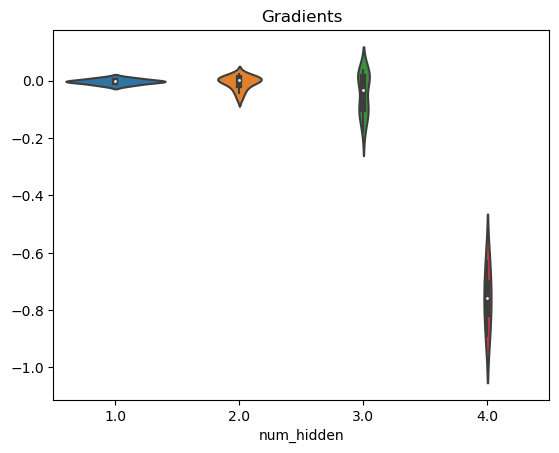

In [32]:
ax = sns.violinplot(y = vp_r[:, 0], x = vp_r[:, 1])
ax.set(xlabel = 'num_hidden', title = 'Gradients')

    小提琴图其实是一种统计分析图像，其基本含义如下所示：

![Alt text](image-42.png)

当然，为了更加全面的观测模型迭代过程中数据和参数的变化情况，我们继续添加用于观测每一层输入数据（也被称为扇入数据），激活函数处理后的输出数据（也被称为扇出数据）以及每一个线性层自身参数情况的小提琴图。

[Text(0.5, 0, 'num_hidden'), Text(0.5, 1.0, 'Weights')]

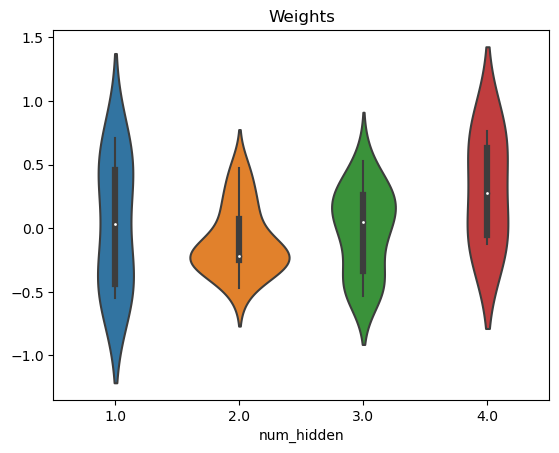

In [33]:
vp = []
for i, m in enumerate(sigmoid_model3.modules()):
    if isinstance(m, nn.Linear):
        vp_x = m.weight.detach().reshape(-1, 1).numpy()
        vp_y = np.full_like(vp_x, i)
        vp_a = np.concatenate((vp_x, vp_y), 1)
        vp.append(vp_a)
vp_r = np.concatenate((vp), 0)
ax = sns.violinplot(y = vp_r[:, 0], x = vp_r[:, 1])
ax.set(xlabel= 'num_hidden', title= 'Weights')

当然，我们也可以将上述过程封装为一个函数。

In [34]:
def weights_vp(model, att = 'grad'):
    """ 观察各层参数取值和梯度的小提琴图绘图函数。
    
    param model: 观察对象（模型）
    param att: 选择参数梯度(grad)还是参数取值(weights)进行观察
    return: 对应att的小提琴图
    """

    vp = []
    for i, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear):
            if att == 'grad':
                vp_x = m.weight.grad.detach().reshape(-1, 1).numpy()
            else:
                vp_x = m.weight.detach().reshape(-1, 1).numpy()
            vp_y = np.full_like(vp_x, i)
            vp_a = np.concatenate((vp_x, vp_y), 1)
            vp.append(vp_a)
    vp_r = np.concatenate((vp), 0)
    ax = sns.violinplot(y = vp_r[:, 0], x = vp_r[:, 1])
    ax.set(xlabel= 'num_hidden', title= att)

测试函数性能

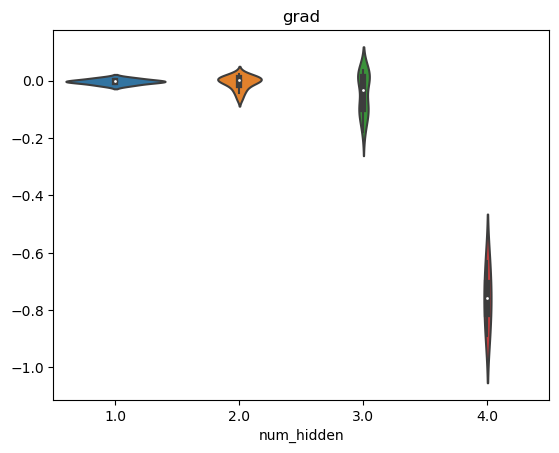

In [35]:
weights_vp(sigmoid_model3, att= 'grad')

值得注意的是，对于Sigmoid激活函数的梯度消失问题，是伴随着迭代次数增加或者隐藏层增加会愈发明显。

In [36]:
fit(net= sigmoid_model3,
    criterion= nn.MSELoss(),
    optimizer= optim.SGD(sigmoid_model3.parameters(), lr= 0.03),
    batchdata= train_loader,
    epochs= 20,
    cla= False)

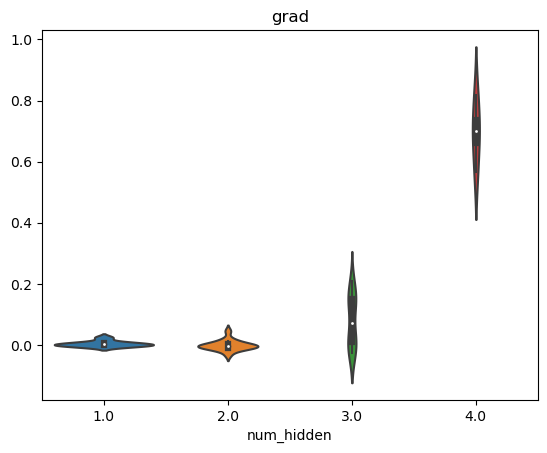

In [37]:
weights_vp(sigmoid_model3, att= 'grad')

至此，我们可以借助上述理论理解Lesson 13.2中Sigmoid激活函数叠加之后所呈现的状态。

![Alt text](image-43.png)

由于Sigmoid激活函数叠加会造成严重梯度消失问题，因此复杂模型，如Sigmoid3和Sigmoid4的前几层在迭代过程中逐渐丧失变化的可能性，也就是学习能力，从而导致经过了很多迭代，但最终结果也只能和Sigmoid2和Sigmoid3持平的情况。

    需要注意的是，对于复杂模型来说，如果部分层失去学习能力（参数迭代的可能性），其实判别模型效力就和简单模型无异，从此也能看出复杂模型进行有效训练的重要性。

## 13.3.3 tanh函数的梯度计算问题

如果说Sigmoid激活函数叠加更容易造成梯度消失问题，那tanh激活函数叠加是不是也如此呢？首先我们来观察tanh激活函数的导数性质。

In [38]:
# 绘制tanh函数的函数图像和导函数图像
x = torch.arange(-5, 5, 0.1)
x.requires_grad = True
tanh_y = torch.tanh(x)

In [39]:
tanh_y.sum().backward()

Text(0.5, 1.0, 'tanh Derivative function')

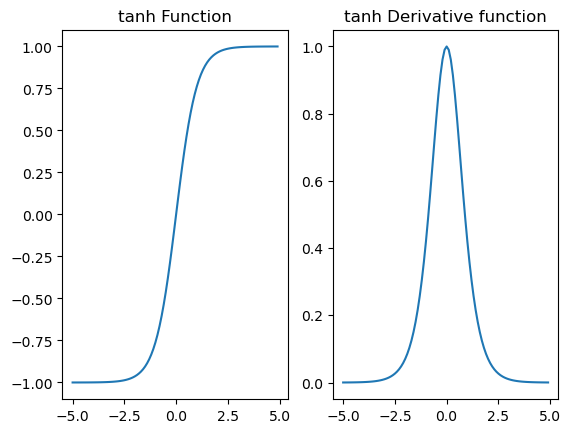

In [40]:
# tanh函数图像
plt.subplot(121)
plt.plot(x.detach(), tanh_y.detach())
plt.title('tanh Function')

# tanh导函数图像
plt.subplot(122)
plt.plot(x.detach(), x.grad.detach())
plt.title('tanh Derivative function')

对于tanh函数来说，导函数的取值分布在0-1之间的，看似导函数取值累乘也是趋于0的，但实际上，tanh激活函数的叠加极有可能造成梯度消失，同时也有可能造成梯度爆炸的，原因是在实际建模过程中，影响前几层梯度的其他变量大多数情况都大于1,因此对于一个导函数的极大值可以取到1的激活函数来说，还是有可能出现梯度爆炸的情况的。

![Alt text](image-44.png) 

    梯度爆炸和梯度消失中，所谓的前几层参数梯度过大或者过小也都是相对的概念，并没有明确定义梯度大过多少就是梯度爆炸，梯度小过多少就是梯度消失。另外，梯度爆炸和梯度消失的直接表现可归结为前后参数梯度不一致，而二者的根本问题都是影响迭代收敛过程。

    作为Sigmoid激活函数的‘升级版’，tanh激活函数除了能够一定程度规避梯度消失问题外，还能够生成Zero-Centered Data,而确保输入层接收到Zero-Centered Data，则是解决梯度消失和梯度爆炸问题的关键。

和Sigmoid激活函数一样，我们可以通过绘制小提琴图观察多轮迭代后，tanh激活函数叠加的神经网络是否会出现梯度消失或者梯度爆炸的情况。类似的，首先我们利用此前定义的模型，实例化一个拥有四个隐藏层的以tanh为激活函数的模型，然后观察模型在迭代过程中梯度变化情况。

In [41]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
tanh_model4 = tanh_class4()

In [42]:
# 观察各层参数
for m in tanh_model4.modules():
    if isinstance(m, nn.Linear):
        print(m.weight)

Parameter containing:
tensor([[ 0.4318, -0.4256],
        [ 0.6730, -0.5617],
        [-0.2157, -0.4873],
        [ 0.5453,  0.2653]], requires_grad=True)
Parameter containing:
tensor([[-0.2552,  0.3644, -0.2104, -0.3271],
        [-0.1542, -0.4883, -0.2428, -0.2728],
        [ 0.1076,  0.4066,  0.0540, -0.2914],
        [ 0.2058, -0.2129, -0.2367, -0.0958]], requires_grad=True)
Parameter containing:
tensor([[ 3.0199e-01, -4.3436e-01, -3.9335e-01, -6.6525e-02],
        [ 4.5806e-04,  3.1209e-01, -4.3974e-01,  2.0861e-01],
        [-4.2916e-01,  8.0655e-02,  3.3044e-01,  6.8971e-02],
        [ 1.5964e-01,  3.1789e-01,  4.9465e-01, -3.1377e-01]],
       requires_grad=True)
Parameter containing:
tensor([[-0.3468, -0.4897,  0.2213,  0.4947],
        [-0.4843,  0.3998, -0.4678, -0.0610],
        [ 0.4057, -0.0786,  0.0555,  0.3645],
        [-0.4194,  0.1265, -0.2440,  0.4589]], requires_grad=True)
Parameter containing:
tensor([[-0.2952,  0.1712, -0.3926,  0.2928]], requires_grad=True)


In [43]:
# 模型训练
train_1, test_1 = model_train_test(tanh_model4,
                                   train_loader,
                                   test_loader,
                                   num_epochs= 5,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= 0.03,
                                   cla= False,
                                   eva= mse_cal
                                    )

In [44]:
# 观察各层参数
for m in tanh_model4.modules():
    if isinstance(m, nn.Linear):
        print(m.weight)

Parameter containing:
tensor([[ 1.1917, -0.0829],
        [ 1.6145, -1.2449],
        [-0.3502, -0.7850],
        [ 1.0127,  0.4339]], requires_grad=True)
Parameter containing:
tensor([[-0.7359, -0.2740, -0.4760, -1.2415],
        [ 0.3107, -0.5648, -0.6705,  0.5070],
        [ 0.6393,  1.3371, -0.0804, -0.1302],
        [ 0.3253, -0.5554, -0.6929,  0.5444]], requires_grad=True)
Parameter containing:
tensor([[ 1.1614, -0.2516, -1.3996, -0.1356],
        [-0.1883,  0.9245, -0.7054,  0.8428],
        [-0.3900,  0.2941,  0.3927,  0.2777],
        [ 0.5467, -0.0234,  0.6829, -0.6355]], requires_grad=True)
Parameter containing:
tensor([[-0.3145, -1.2521, -0.0183,  0.9920],
        [-1.1792,  0.8296, -0.5753, -0.0729],
        [ 1.5959, -0.1902, -0.4933,  0.2802],
        [-1.3985,  0.6193,  0.2000,  0.3402]], requires_grad=True)
Parameter containing:
tensor([[-3.2054,  0.9657, -2.2879,  1.4430]], requires_grad=True)


In [45]:
# 观察各层梯度
for m in tanh_model4.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-0.0395, -0.0078],
        [ 0.0128,  0.0110],
        [ 0.0288,  0.0092],
        [-0.0292, -0.0080]])
tensor([[-0.0020,  0.0028, -0.0047, -0.0030],
        [ 0.0246, -0.0293,  0.0609,  0.0343],
        [ 0.0404,  0.0002,  0.0497,  0.0450],
        [ 0.0232, -0.0247,  0.0557,  0.0314]])
tensor([[ 0.0275, -0.0016,  0.0601,  0.0005],
        [ 0.0113,  0.0035, -0.0571,  0.0022],
        [-0.2748, -0.1494,  0.2194, -0.1520],
        [ 0.0050,  0.0020,  0.0059,  0.0023]])
tensor([[-0.0152, -0.0134,  0.0089,  0.0196],
        [ 0.7131,  0.6994, -0.1653, -0.5388],
        [-0.1053, -0.1032,  0.0242,  0.0853],
        [ 0.3351,  0.3271, -0.0836, -0.2693]])
tensor([[-0.7371, -0.0367,  0.7157, -0.6173]])


通过小提琴图进行观察

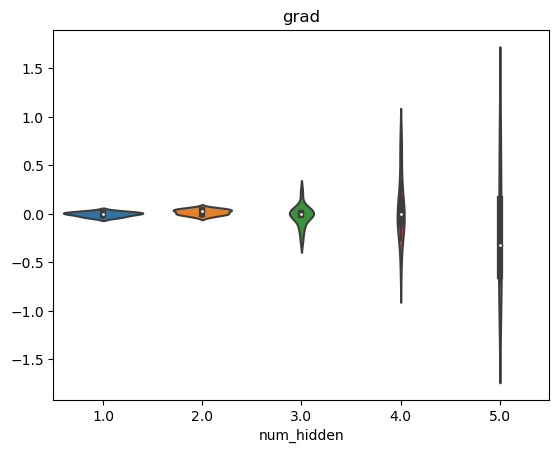

In [46]:
weights_vp(tanh_model4, att='grad')

从上述结果能够看出各层中梯度分布严重不均，并且前几层个别梯度存在极端不均衡的情况

能够看出，上述模型存在一定程度的梯度爆炸情况。当然，对于tanh激活函数来说，由于激活函数本身的良好特性（也就是能够输出 Zero-Centered Data），一般不会出现典型的梯度消失情况。但梯度爆炸同样会极大影响模型训练过程的稳定性，并且这种现象并不会因为模型迭代次数增加而消失。

In [47]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
tanh_model4 = tanh_class4()

# 模型训练
train_1, test_1 = model_train_test(tanh_model4,
                                   train_loader,
                                   test_loader,
                                   num_epochs= 20,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = 0.03,
                                   cla= False,
                                   eva= mse_cal)

In [48]:
# 观察各层梯度
for m in tanh_model4.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-1.1270,  0.9406],
        [-0.5357, -0.0438],
        [ 0.0242, -0.0034],
        [-0.0621,  0.0068]])
tensor([[ 4.1319e-03,  3.8302e-03, -5.4455e-03, -5.2517e-03],
        [ 5.7088e-05, -8.6474e-04,  9.1992e-04,  9.1166e-04],
        [-4.9178e-01, -4.2399e-01, -3.4477e-01, -3.5506e-01],
        [-1.0618e-01, -1.0129e+00,  1.1180e-01,  1.0027e-01]])
tensor([[ 0.4322,  0.4329,  0.3904,  0.0224],
        [-0.2174, -0.2172, -0.1812,  0.1066],
        [ 0.4628,  0.4628, -0.2060, -0.3868],
        [-0.1129, -0.1129,  0.0950, -0.0841]])
tensor([[ 0.0049,  0.0054,  0.0054,  0.0053],
        [-0.0164, -0.0198, -0.0191, -0.0158],
        [ 0.0673,  0.1104,  0.1101,  0.1057],
        [-3.9953, -4.0054, -3.9884, -4.0236]])
tensor([[ 1.5895,  1.5878, -1.5609,  0.0050]])


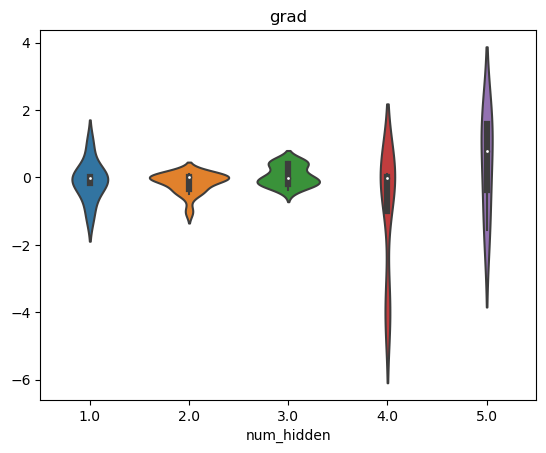

In [49]:
weights_vp(tanh_model4, att='grad')

我们发现，随着迭代次数增加，这种梯度爆炸的情况有增无减。从该角度出发，我们也能理解为何tanh4在Lesson 13.2 中迭代过程如此不平稳的原因。

![Alt text](image-45.png)

从根本上来说，tanh激活函数的迭代不平稳就是因为部分层的部分梯度存在极端值，当然，这种极端值也导致部分层无法有效学习，最终影响模型效果。

## 13.3.4 Zero-Centered Data 与 Glorot条件

通过对Sigmoid和tanh激活函数叠加后的模型梯度变化情况分析，我们不难发现，梯度不平稳是影响模型建模效果的非常核心的因素。而这个看似简单问题的解决方案，却花费了研究人员数十年的时间才逐渐完善，我们现在所接触到的优化方法，也基本上是在15年前后提出的，而这些被验证的切实可行的优化方法，也是推动这一轮深度学习浪潮的技术因素。

    当然，这些优化方法主要是针对深层神经网络的。

整体来看，针对梯度不平稳的解决方案（优化方法）总共分为五类，分别是参数初始化方法，输入数据的归一化方法，衍生激活函数使用方法，学习率调度方法以及梯度下降优化方法。接下来，先介绍上述所有优化算法的一个基本理论，由Xavier Glorot在2010提出的Glorot条件。

    值得注意的是，虽然不同优化算法有着不同的出发点和不同的论证方式，但基本都可以从Glorot条件。

### 13.3.4.1 Zero-Centered Data

在介绍Glorot条件之前，我们先从一个更加朴素的角度出发，讨论关于Zero-Centered Data相关作用，从而帮助我们理解后续Glorot条件。

首先，我们还是假设当前模型是一个三层神经网络，其中两个隐藏层的激活函数为 $ F(x) $ ,对应的导函数为 $ f(x) $ ,设x为输入训练的数据特征，y 为标签，y^为模型向前输出结果， $ w_{1} $ 为第一层参数，$ w_{2} $ 为第二层参数，$ w_{3} $ 为第三层参数，loss为损失函数，则有如下计算公式：

每一次正向传播计算结果：

$$
\hat{y}=F\left(F\left(X * w_1\right) * w_2\right) * w_3
$$

假设 $ Z_{i} $ 为第i层接收到的数据，$ P_{i} $为第i层输出的数据，则有：

$$
\begin{gathered}
Z_1=X * w_1 \\
P_1=F\left(Z_1\right)=F\left(X * w_1\right) \\
Z_2=P_1 * w_2=F\left(X * w_1\right) * w_2 \\
P_2=F\left(Z_2\right)=F\left(F\left(X * w_1\right) * w_2\right) \\
Z_3=\hat{y}=F\left(F\left(X * w_1\right) * w_2\right) * w_3
\end{gathered}
$$

依次类推，而在反向传播过程，各参数层的梯度如下：

$$
\begin{gathered}
\operatorname{grad}_1=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot w_2 \cdot f\left(X * w_1\right) \cdot X \\
\operatorname{grad}_2=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot F\left(X * w_1\right) \\
\operatorname{grad}_3=\frac{\partial l o s s}{\partial \hat{y}} \cdot F\left(F\left(X * w_1\right) * w_2\right)
\end{gathered}
$$

在梯度消失和梯度爆炸的案例中，我们不难发现，为了确保多层神经网络的有效性，各层梯度的差距不应太大，此时一个最为基本的想法就是，就是能否让所有的输入数据（也就是X）以及所有层的参数都设置为Zero-Centered Data,也就是零点对称数据，不难发现，由于X和 $ w_{i} $都是零点对称的，因此每一个线性层中的导函数的取值也就能维持在0-1之间，进而每一层的梯度基本能维持在比较平稳的状态。

    另外，除了能够避免梯度不平稳问题以外，创建Zero-Centered的参数和数据集，还能更好的在正向传播中将信息传播到各层，以确保各层学习的平稳性。

关于如何将带入模型的训练数据转化为Zero-Centered Data，一般来说我们会使用一系列标准化的方法对其进行转化，具体方法我们会在Lesson 14进行详细介绍，由于我们此前创建的数据生成器就是Zero-Centered Data，因此暂时这些数据不会影响接下来的优化方法的使用。而如何将参数转化为Zero-Centered Data，就是核心需要考虑的问题了。

    对于输入的数据来说，我们可以尽量保证其Zero-Centered的特性，但模型参数是随着模型迭代不断变化的，我们无法把控模型每一轮迭代后的情况，因此只能从模型参数初始值入手，尽量保证其Zero-Centered属性。

当然，既然是创建Zero-Centered参数，那能否创建初始值全是0的参数呢？我们可以简单尝试一下：

In [50]:
class Sigmoid_class1_test(nn.Module):
    def __init__(self, in_features = 2, n_hidden = 2, out_features = 1, bias = False):
        super().__init__()
        self.linear1 = nn.Linear(in_features, n_hidden, bias= bias)
        self.linear2 = nn.Linear(n_hidden, out_features, bias= bias)
    
    def forward(self, x):
        z1 = self.linear1(x)
        p1 = torch.sigmoid(z1)
        out = self.linear2(p1)
        return out

# 创建随机数种子
torch.manual_seed(420)

# 创建模型
sigmoid_test = Sigmoid_class1_test()

In [51]:
# 观察各层参数
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[ 0.4318, -0.4256],
         [ 0.6730, -0.5617]], requires_grad=True),
 Parameter containing:
 tensor([[-0.2157, -0.4873]], requires_grad=True)]

In [52]:
# 将各层参数修改为0
list(sigmoid_test.parameters())[0].data = torch.tensor([[0, 0], [0, 0]], dtype= torch.float32)
list(sigmoid_test.parameters())[1].data = torch.tensor([[0, 0]], dtype= torch.float32)

In [53]:
# 查看修改结果
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[0., 0.],
         [0., 0.]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0.]], requires_grad=True)]

In [54]:
 # 遍历五次查看结果
fit(net= sigmoid_test,
    criterion= nn.MSELoss(),
    optimizer= optim.SGD(sigmoid_test.parameters(), lr= 0.03),
    batchdata= train_loader,
    epochs= 5,
    cla= False)

In [55]:
list(sigmoid_test.parameters())

[Parameter containing:
 tensor([[ 0.6172, -0.0184],
         [ 0.6172, -0.0184]], requires_grad=True),
 Parameter containing:
 tensor([[0.9556, 0.9556]], requires_grad=True)]

我们发现，参数的每一列（最后一个参数的一行）都是同步变化的，大家可以思考一下出现这种情况的原因是什么？

很明显，我们不能即哪个参数的初始值全部设置为0,我们只能考虑借助统计工具生成均值是0的随机数，也就是0均值的均匀分布或者是0均值的高斯分布，但这里需要考虑的另一个问题是，该随机数的方差应该如何确定呢？

### 13.3.4.2 Glorot条件和Xavier方法

初始化参数的方差如何确定这一问题在一个严谨论述如何保证模型有效性的论文中，从另一个角度出发，得到了回答。根据Xavier Glorot在2010年发表的 《Understanding the difficulty of training deep feedforward neural networks》论文中的观点，为保证模型本身的有效性和稳定性，我们希望正向传播时，每个线性层输入数据的方差等与输出数据的方差，同时我们也希望反向传播时，数据流经某层之前和流经某层之后该层的梯度也具有相同的方差，虽然二者很难同时满足（除非相邻两层神经元个数相同），但Glorot和Bengio（论文第二作者）表示，如果我们适当修改计算过程，是可以找到一种折中方案去设计初始参数取值，从而同时保证二者条件尽可能得到满足，这种设计参数初始值的方法也被称为Xavier方法，而这种方法也经过一段时间的实践验证被证明是很好的一种初始化模型参数的方法，尤其是对于使用tanh激活函数的神经网络来说，效果更为显著。

而这种正向传播时数据方差保持一致，反向传播时参数梯度方差保持一致的条件，也被称为Glorot条件，满足该条件的模型能够进行有效平稳的训练，而为了满足该条件而创建的模型参数初始化设计方法，也被称为Xavier方法。而在Xavier方法种，最核心解决的问题，也就是为了创建 Zero-Centered的初始化参数时参数的方差。和我们从朴素的角度思考的方向时一致的。

由于Glorot条件和Xavier方法是在2010年提出的，彼时ReLu激活函数还未兴起，因此Xavier方法主要是围绕tanh激活函数可能存在的梯度爆炸或者梯度消失进行的优化，sigmoid激活函数效果次之。不过尽管如此，Glorot条件却是一个通用条件，后续围绕Relu激活函数，用于解决神经元活性失效的优化方法（如HE初始化方法），也是遵照Glorot条件进行的方法设计。

### 13.3.4.3 模型初始化参数取值影响

Xavier初始化方法的推导和使用我们将在下一节详细介绍，此处我们先通过另一实例，去展示为何初始参数取值不同，会得到不同的建模结果。模型初始化时得到的不同参数，本质上等价于在损失函数上找到了不同的初始点，而同一损失函数，初始点选取的不同应该不会影响最终迭代结果才对，但事实情况并非如此。

![Alt text](image-49.png)

就以此前介绍的出现神经元活性失效的relu_model3来说，换了初始参数值，情况就可能完全不同。在模型实例化过程中，采用不同随机数种子，就相当于选取了不同的模型初始化参数。

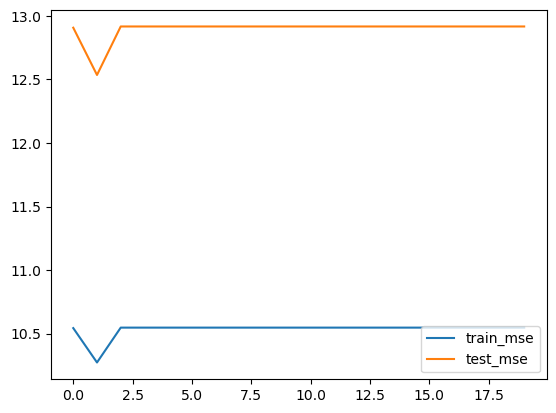

In [56]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3(bias= False)      #  为了更方便的观察神经元活性失效问题，我们创建不带截距的模型

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_1, test_1 = model_train_test(relu_model3,
                                   train_loader,
                                   test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= 0.03,
                                   cla= False,
                                   eva= mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_1, label = 'train_mse')
plt.plot(list(range(num_epochs)), test_1, label = 'test_mse')
plt.legend(loc = 4)

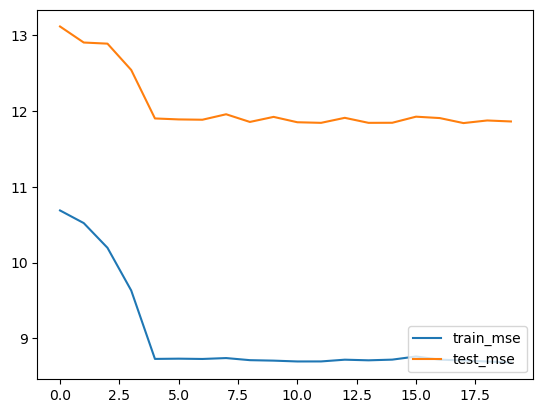

In [57]:
# 创建随机数种子
torch.manual_seed(29)

# 实例化模型
relu_model3 = Relu_class3(bias= False)      #  为了更方便的观察神经元活性失效问题，我们创建不带截距的模型

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_1, test_1 = model_train_test(relu_model3,
                                   train_loader,
                                   test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= 0.03,
                                   cla= False,
                                   eva= mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_1, label = 'train_mse')
plt.plot(list(range(num_epochs)), test_1, label = 'test_mse')
plt.legend(loc = 4)